**1. Load and normalize CIFAR10**

In [1]:
import torch
import torchvision
import torchvision.transforms as transforms

In [2]:
#define our device as the first visible cuda device if we have CUDA available

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

# Assuming that we are on a CUDA machine, this should print a CUDA device:

print(device)

cuda:0


In [3]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

batch_size = 4

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                          shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=batch_size,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**2. Define a Standard Convolutional Neural Network and a Convolutional Neural Network with TT-layer**

In [4]:
import torch.nn as nn
import torch.nn.functional as F


class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 输出: 32x32x16
        self.pool1 = nn.MaxPool2d(2, 2)  # 输出: 16x16x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 输出: 16x16x32
        self.pool2 = nn.MaxPool2d(2, 2)  # 输出: 8x8x32
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)  # 输出: 8x8x16
        self.pool3 = nn.MaxPool2d(2, 2)  # 输出: 4x4x16 => 展平后是 4*4*16 = 256 个元素
        self.conv4 = nn.Conv2d(16, 64, kernel_size=3, padding=1)  # 输出: 4x4x64
        # 展平后是 4*4*64 = 1024 个元素

        self.fc1 = nn.Linear(1024,243)
        self.fc2 = nn.Linear(243, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))

        # 打印形状，确认展平后是1024
        # print(f"Shape before flatten: {x.shape}")
        
        x = torch.flatten(x, 1) # flatten all dimensions except batch
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

In [5]:
class TTNet(nn.Module):
    def __init__(self,tt_rank):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=3, padding=1)  # 输出: 32x32x16
        self.pool1 = nn.MaxPool2d(2, 2)  # 输出: 16x16x16
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)  # 输出: 16x16x32
        self.pool2 = nn.MaxPool2d(2, 2)  # 输出: 8x8x32
        self.conv3 = nn.Conv2d(32, 16, kernel_size=3, padding=1)  # 输出: 8x8x16
        self.pool3 = nn.MaxPool2d(2, 2)  # 输出: 4x4x16 => 展平后是 4*4*16 = 256 个元素
        self.conv4 = nn.Conv2d(16, 64, kernel_size=3, padding=1)  # 输出: 4x4x64
        
        import torchtt as tntt
        self.tt_rank = tt_rank
        self.ttl1 = tntt.nn.LinearLayerTT([4,4,4,4,4], [3,3,3,3,3], [1,tt_rank,tt_rank,tt_rank,tt_rank,1])
        self.fc2 = nn.Linear(243, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.pool3(F.relu(self.conv3(x)))
        x = F.relu(self.conv4(x))
        x = torch.flatten(x, 1)
        # 重塑为TT层所需的形状
        batch_size = x.shape[0]
        x = x.reshape(batch_size, 4, 4, 4, 4, 4)  # 4^5 = 1024
        x = F.relu(self.ttl1(x))
        # 重塑回二维形状以通过全连接层
        x = x.reshape(batch_size, -1)  # 应该是 [batch_size, 243]
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

**3.Train and test all the networks**

In [ ]:
# 函数：计算准确率
def accuracy(model, dataloader, device):
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, labels in dataloader:
            inputs, labels = inputs.to(device), labels.to(device)
            outputs = model(inputs)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    return correct / total

# 函数：计算模型的参数量
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

In [7]:
import time

num_epochs = 5
# 初始化 TT秩，探究accuracy,compression rate和tt rank的关系
tt_ranks = [2, 3, 4, 5, 6, 7, 8, 9]
# # 初始化 TensorBoard SummaryWriter
# writer = SummaryWriter()

# 用于存储不同 tt_rank 下的准确率历史和其他统计数据
results = {}

# ==================== 先训练标准模型 ====================
print("==== 训练标准模型 ====")
net = Net().to(device)  # 使用GPU
optimizer_net = torch.optim.SGD(net.parameters(), lr=0.001, momentum=0.9)
criterion = nn.CrossEntropyLoss()

# 存储标准模型的数据
accuracy_history_net = []
loss_history_net = []
time_history_net = []

# 标准模型的训练循环
for epoch in range(num_epochs):
    print(f'Epoch {epoch+1}/{num_epochs}:')
    
    # 训练标准模型
    start_time_net = time.time()
    
    running_loss_net = 0.0
    total_loss_net = 0.0
    batch_count = 0
    net.train()
    
    for i, data in enumerate(trainloader, 0):
        # 获取输入数据
        inputs, labels = data[0].to(device), data[1].to(device)
        
        # 梯度清零
        optimizer_net.zero_grad()
        
        # 前向传播 + 反向传播 + 优化
        outputs = net(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer_net.step()
        
        # 统计损失
        running_loss_net += loss.item()
        total_loss_net += loss.item()
        batch_count += 1
        
        if i % 2000 == 1999:
            print(f'[{epoch + 1}, {i + 1:5d}] net loss: {running_loss_net / 2000:.3f}')
            running_loss_net = 0.0
    
    # 计算训练时间
    end_time_net = time.time()
    epoch_time_net = end_time_net - start_time_net
    time_history_net.append(epoch_time_net)
    
    # 计算并记录平均每个epoch的损失
    epoch_loss_net = total_loss_net / batch_count
    loss_history_net.append(epoch_loss_net)
    
    # 评估标准模型
    net.eval()
    acc_net = accuracy(net, testloader, device)
    accuracy_history_net.append(acc_net)
    
    print(f'  Net - Loss: {epoch_loss_net:.4f}, Acc: {acc_net:.4f}, Time: {epoch_time_net:.2f}s')
    print('-'*40)

# 计算标准模型的总统计
total_time_net = sum(time_history_net)
avg_time_net = total_time_net / num_epochs
params_net = count_parameters(net)

print(f'标准模型训练完成')
print(f'Model Parameters: {params_net:,}')
print(f'Training Time: {total_time_net:.2f}s (avg: {avg_time_net:.2f}s/epoch)')
print(f'Final Accuracy: {accuracy_history_net[-1]:.4f}')
print("="*60)

# ==================== 接下来训练不同TT秩的TT模型 ====================

for tt_rank in tt_ranks:
    print(f"==== 训练 TT 秩 = {tt_rank} 的模型 ====")
    
    # 创建TT模型，使用当前的TT秩
    ttnet = TTNet(tt_rank=tt_rank).to(device)
    
    # 优化器设置
    optimizer_ttnet = torch.optim.SGD(ttnet.parameters(), lr=0.001, momentum=0.9)
    
    # 用于存储每个 epoch 的准确率和损失数据
    accuracy_history_ttnet = []
    loss_history_ttnet = []
    time_history_ttnet = []
    
    # 训练TT模型循环
    for epoch in range(num_epochs):
        print(f'TT Rank {tt_rank} - Epoch {epoch+1}/{num_epochs}:')
        
        # 训练TT模型
        start_time_ttnet = time.time()
        
        running_loss_ttnet = 0.0
        total_loss_ttnet = 0.0
        batch_count = 0
        ttnet.train()
        
        for i, data in enumerate(trainloader, 0):
            # 获取输入数据
            inputs, labels = data[0].to(device), data[1].to(device)
            
            # 梯度清零
            optimizer_ttnet.zero_grad()
            
            # 前向传播 + 反向传播 + 优化
            outputs = ttnet(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer_ttnet.step()
            
            # 统计损失
            running_loss_ttnet += loss.item()
            total_loss_ttnet += loss.item()
            batch_count += 1
            
            if i % 2000 == 1999:
                print(f'[{epoch + 1}, {i + 1:5d}] ttnet loss: {running_loss_ttnet / 2000:.3f}')
                running_loss_ttnet = 0.0
        
        # 计算训练时间
        end_time_ttnet = time.time()
        epoch_time_ttnet = end_time_ttnet - start_time_ttnet
        time_history_ttnet.append(epoch_time_ttnet)
        
        # 计算并记录平均每个epoch的损失
        epoch_loss_ttnet = total_loss_ttnet / batch_count
        loss_history_ttnet.append(epoch_loss_ttnet)
        
        # 评估TT模型
        ttnet.eval()
        acc_ttnet = accuracy(ttnet, testloader, device)
        accuracy_history_ttnet.append(acc_ttnet)
        
        # 打印当前 epoch 的结果
        print(f'  TTNet - Loss: {epoch_loss_ttnet:.4f}, Acc: {acc_ttnet:.4f}, Time: {epoch_time_ttnet:.2f}s')
        print(f'  速度比较: 标准模型 {time_history_net[epoch]:.2f}s vs TT模型 {epoch_time_ttnet:.2f}s')
        print(f'  速度比: {time_history_net[epoch]/epoch_time_ttnet:.2f}x')
        print('-'*40)
    
    # ==================== 计算当前TT秩的总结统计 ====================
    print(f'TT Rank {tt_rank} 训练完成')
    
    # 计算总训练时间和平均时间
    total_time_ttnet = sum(time_history_ttnet)
    avg_time_ttnet = total_time_ttnet / num_epochs
    overall_speed_ratio = total_time_net / total_time_ttnet
    
    # 计算TT模型的参数量和压缩比
    params_ttnet = count_parameters(ttnet)
    compression_ratio = params_net / params_ttnet
    
    # 打印最终结果
    print(f'Model Parameters:')
    print(f'  标准模型: {params_net:,} parameters')
    print(f'  TT模型: {params_ttnet:,} parameters')
    print(f'  压缩比: {compression_ratio:.2f}x')
    
    print(f'Training Time:')
    print(f'  标准模型: {total_time_net:.2f}s (avg: {avg_time_net:.2f}s/epoch)')
    print(f'  TT模型: {total_time_ttnet:.2f}s (avg: {avg_time_ttnet:.2f}s/epoch)')
    print(f'  速度比: {overall_speed_ratio:.2f}x')
    
    print(f'Final Accuracy:')
    print(f'  标准模型: {accuracy_history_net[-1]:.4f}')
    print(f'  TT模型: {accuracy_history_ttnet[-1]:.4f}')
    
    # 存储所有数据到结果字典
    results[tt_rank] = {
        'accuracy_ttnet': accuracy_history_ttnet,
        'loss_ttnet': loss_history_ttnet,
        'time_ttnet': total_time_ttnet,
        'params_ttnet': params_ttnet,
        'compression_ratio': compression_ratio,
        'speed_ratio': overall_speed_ratio
    }
    
    print("="*60)

# 将标准模型的数据存储到结果中，便于后续绘图
for tt_rank in tt_ranks:
    results[tt_rank]['accuracy_net'] = accuracy_history_net.copy()
    results[tt_rank]['loss_net'] = loss_history_net.copy()
    results[tt_rank]['time_net'] = total_time_net
    results[tt_rank]['params_net'] = params_net

==== 训练标准模型 ====
Epoch 1/5:
[1,  2000] net loss: 2.300
[1,  4000] net loss: 2.202
[1,  6000] net loss: 1.933
[1,  8000] net loss: 1.718
[1, 10000] net loss: 1.596
[1, 12000] net loss: 1.505
  Net - Loss: 1.8590, Acc: 0.4553, Time: 37.56s
----------------------------------------
Epoch 2/5:
[2,  2000] net loss: 1.412
[2,  4000] net loss: 1.375
[2,  6000] net loss: 1.313
[2,  8000] net loss: 1.264
[2, 10000] net loss: 1.209
[2, 12000] net loss: 1.196
  Net - Loss: 1.2899, Acc: 0.5622, Time: 37.06s
----------------------------------------
Epoch 3/5:
[3,  2000] net loss: 1.117
[3,  4000] net loss: 1.107
[3,  6000] net loss: 1.087
[3,  8000] net loss: 1.052
[3, 10000] net loss: 1.043
[3, 12000] net loss: 1.017
  Net - Loss: 1.0670, Acc: 0.6380, Time: 37.23s
----------------------------------------
Epoch 4/5:
[4,  2000] net loss: 0.925
[4,  4000] net loss: 0.952
[4,  6000] net loss: 0.957
[4,  8000] net loss: 0.938
[4, 10000] net loss: 0.937
[4, 12000] net loss: 0.933
  Net - Loss: 0.9400, Ac

[1,  2000] ttnet loss: 2.303
[1,  4000] ttnet loss: 2.298
[1,  6000] ttnet loss: 2.088
[1,  8000] ttnet loss: 1.767
[1, 10000] ttnet loss: 1.609
[1, 12000] ttnet loss: 1.539
  TTNet - Loss: 1.9154, Acc: 0.4690, Time: 101.97s
  速度比较: 标准模型 37.56s vs TT模型 101.97s
  速度比: 0.37x
----------------------------------------
TT Rank 2 - Epoch 2/5:
[2,  2000] ttnet loss: 1.417
[2,  4000] ttnet loss: 1.373
[2,  6000] ttnet loss: 1.301
[2,  8000] ttnet loss: 1.278
[2, 10000] ttnet loss: 1.208
[2, 12000] ttnet loss: 1.218
  TTNet - Loss: 1.2959, Acc: 0.5966, Time: 51.76s
  速度比较: 标准模型 37.06s vs TT模型 51.76s
  速度比: 0.72x
----------------------------------------
TT Rank 2 - Epoch 3/5:
[3,  2000] ttnet loss: 1.126
[3,  4000] ttnet loss: 1.099
[3,  6000] ttnet loss: 1.088
[3,  8000] ttnet loss: 1.053
[3, 10000] ttnet loss: 1.041
[3, 12000] ttnet loss: 1.056
  TTNet - Loss: 1.0766, Acc: 0.6261, Time: 49.25s
  速度比较: 标准模型 37.23s vs TT模型 49.25s
  速度比: 0.76x
----------------------------------------
TT Rank 2 - E

**4.Visualize the results and Compare**

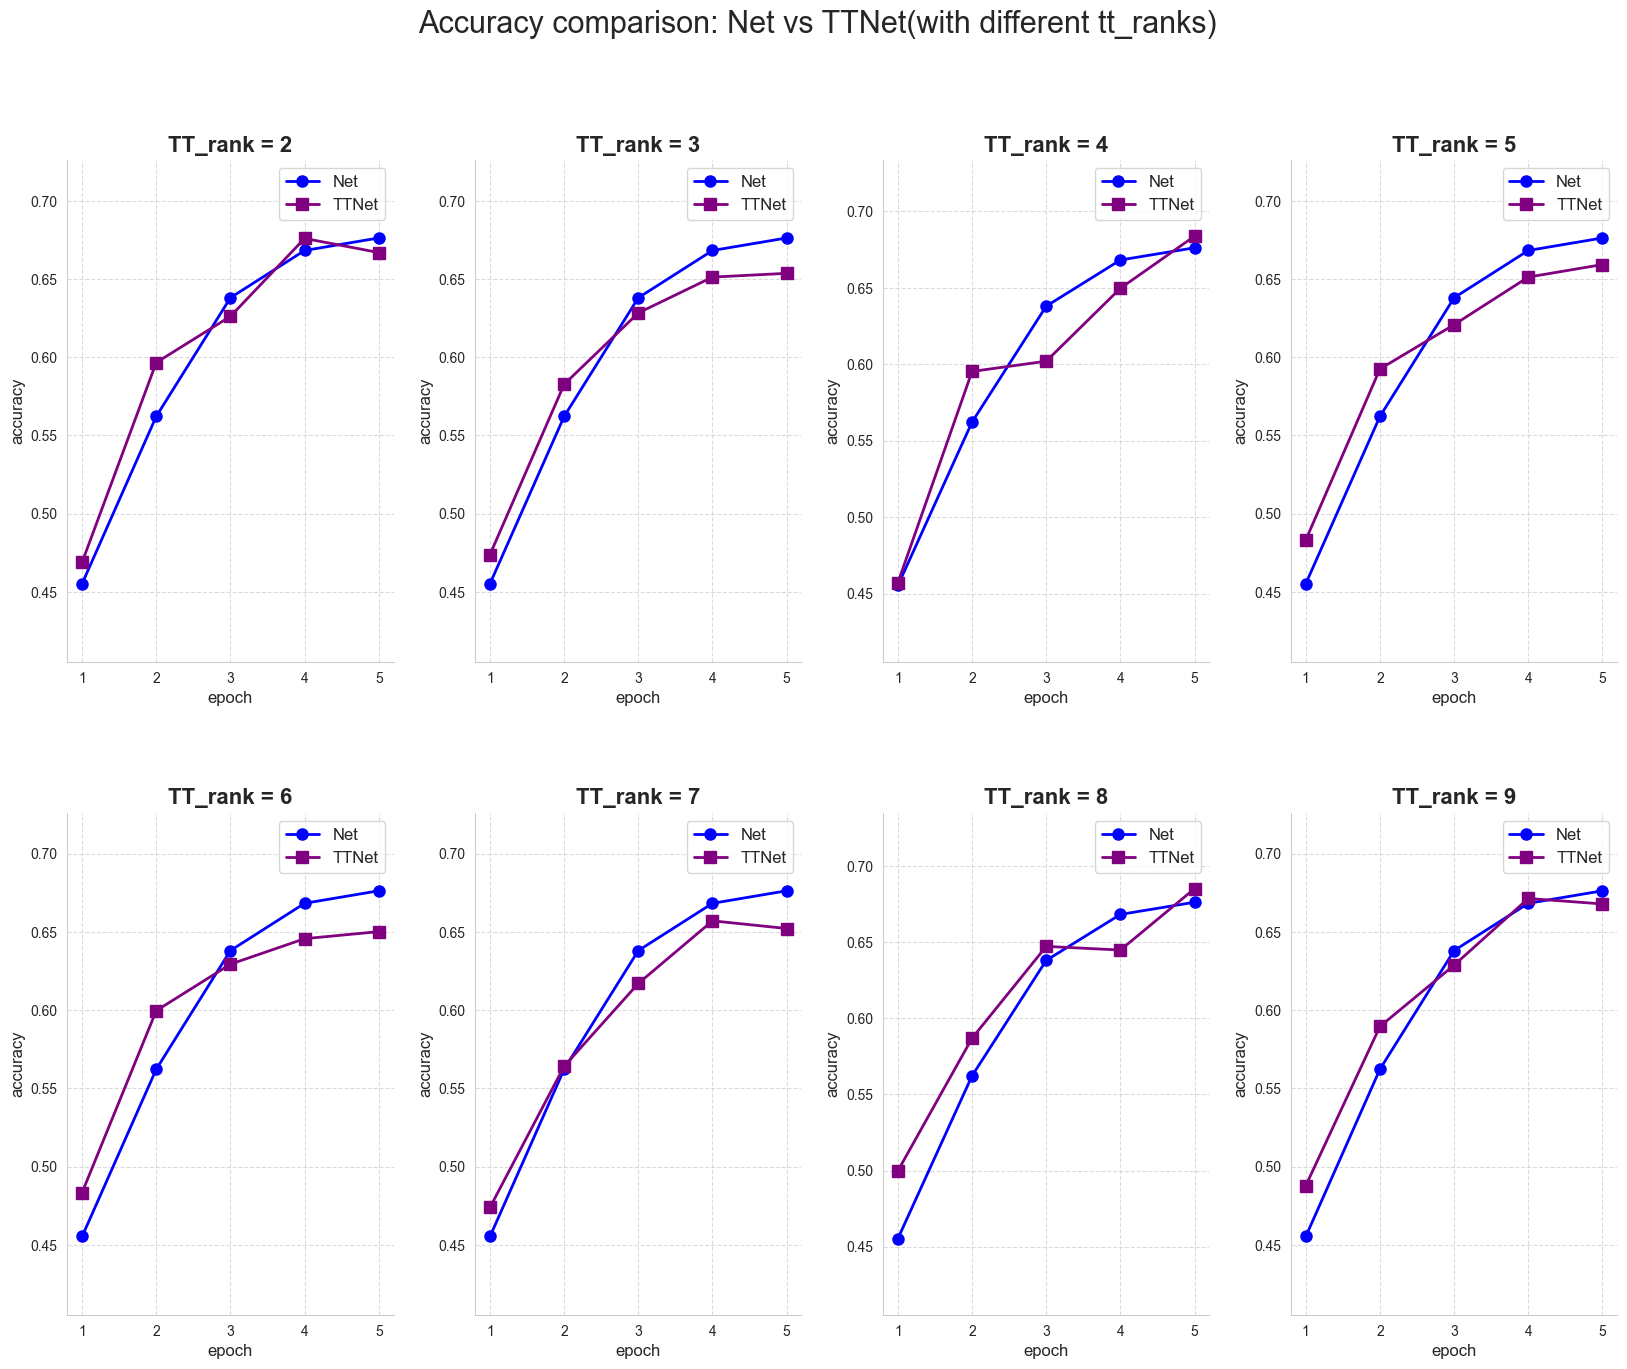

,TT_rank,Parameter of Net,Parameter of TTNet,Compression ratio,Training time of Net(s),Training time of TTNet(s),Speed ratio,Eventual accuracy of Net,Eventual accuracy of TTNet
0,2,"289,413","40,773",7.10x,195.85,361.62,0.54x,0.6762,0.6669
1,3,"289,413","40,977",7.06x,195.85,481.13,0.41x,0.6762,0.6536
2,4,"289,413","41,253",7.02x,195.85,310.70,0.63x,0.6762,0.6838
3,5,"289,413","41,601",6.96x,195.85,450.03,0.44x,0.6762,0.6592
4,6,"289,413","42,021",6.89x,195.85,394.90,0.50x,0.6762,0.6501
5,7,"289,413","42,513",6.81x,195.85,273.08,0.72x,0.6762,0.6521
6,8,"289,413","43,077",6.72x,195.85,393.38,0.50x,0.6762,0.6851
7,9,"289,413","43,713",6.62x,195.85,248.55,0.79x,0.6762,0.6678


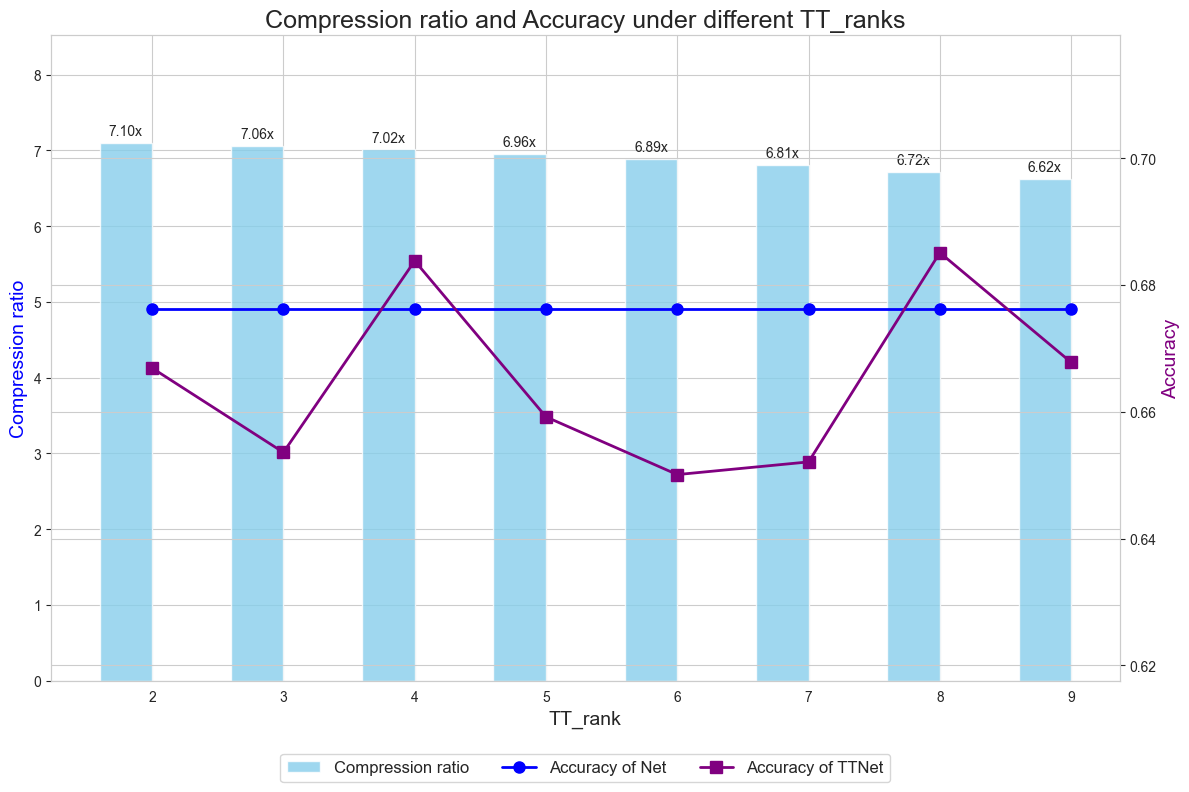

In [19]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.gridspec import GridSpec
import pandas as pd
from IPython.display import display
import seaborn as sns
from matplotlib.font_manager import FontProperties

plt.rcParams['font.sans-serif'] = ['SimHei']  # 设置默认字体为黑体
plt.rcParams['axes.unicode_minus'] = False  # 解决保存图像时负号'-'显示为方块的问题

# ==================== 可视化结果 ====================

# 1. 创建包含8个子图的大图，比较不同TT秩下的模型准确率
plt.figure(figsize=(20, 15))
sns.set_style("whitegrid")

# 使用GridSpec创建更精确的子图布局
gs = GridSpec(2, 4, figure=plt.gcf(), hspace=0.3, wspace=0.25)

# 定义颜色和样式
net_color = 'blue'
ttnet_color = 'purple'

for i, rank in enumerate(tt_ranks):
    row = i // 4
    col = i % 4
    ax = plt.subplot(gs[row, col])
    
    # 获取准确率数据
    acc_net = results[rank]['accuracy_net']
    acc_ttnet = results[rank]['accuracy_ttnet']
    epochs = range(1, num_epochs + 1)
    
    # 绘制准确率曲线
    ax.plot(epochs, acc_net, '-o', color=net_color, linewidth=2, markersize=8, label='Net')
    ax.plot(epochs, acc_ttnet, '-s', color=ttnet_color, linewidth=2, markersize=8, label='TTNet')
    
    # 设置图表样式
    ax.set_title(f'TT_rank = {rank}', fontsize=16, fontweight='bold')
    ax.set_xlabel('epoch', fontsize=12)
    ax.set_ylabel('accuracy', fontsize=12)
    ax.grid(True, linestyle='--', alpha=0.7)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    
    # Y轴范围设置，确保所有图表使用相同的比例
    ymin = min(min(acc_net), min(acc_ttnet)) - 0.05
    ymax = max(max(acc_net), max(acc_ttnet)) + 0.05
    ax.set_ylim(max(0, ymin), min(1.0, ymax))
    
    # 添加网格线
    ax.grid(True, linestyle='--', alpha=0.7)
    
    #显示图例
    ax.legend(fontsize=12)

# 添加总标题
plt.suptitle('Accuracy comparison: Net vs TTNet(with different tt_ranks)', fontsize=22, y=0.98)

# 保存图表
plt.savefig('accuracy_comparison_by_tt_rank.png', dpi=300, bbox_inches='tight')
plt.show()

# 2. 创建统计表格
# 准备表格数据
table_data = []
for rank in tt_ranks:
    data = results[rank]
    table_data.append({
        'TT_rank': rank,
        'Parameter of Net': f"{data['params_net']:,}",
        'Parameter of TTNet': f"{data['params_ttnet']:,}",
        'Compression ratio': f"{data['compression_ratio']:.2f}x",
        'Training time of Net(s)': f"{data['time_net']:.2f}",
        'Training time of TTNet(s)': f"{data['time_ttnet']:.2f}",
        'Speed ratio': f"{data['speed_ratio']:.2f}x",
        'Eventual accuracy of Net': f"{data['accuracy_net'][-1]:.4f}",
        'Eventual accuracy of TTNet': f"{data['accuracy_ttnet'][-1]:.4f}",
    })

# 创建DataFrame展示
df = pd.DataFrame(table_data)

# 设置样式
styler = df.style.set_caption("The performance comparison of models in different TT_ranks").set_table_styles([
    {'selector': 'caption', 'props': [('font-size', '16px'), ('font-weight', 'bold')]},
    {'selector': 'th', 'props': [('text-align', 'center'), ('background-color', '#f0f0f0')]},
    {'selector': 'td', 'props': [('text-align', 'center')]}
])

# 高亮显示压缩比和速度比
def highlight_compression(val):
    try:
        val = float(val.replace('x', ''))
        if val > 5:
            return 'background-color: rgba(76, 175, 80, 0.3)'  # 绿色 - 高压缩率
        return ''
    except:
        return ''

styler = styler.applymap(highlight_compression, subset=['Compression ratio', 'Speed ratio'])

# 显示表格
display(styler)

# 3. 创建一个单独的图表，展示不同TT秩下的压缩率和准确率变化
plt.figure(figsize=(12, 8))
ax1 = plt.gca()
ax2 = ax1.twinx()

# 提取数据
ranks_list = list(results.keys())
compression_ratios = [results[r]['compression_ratio'] for r in ranks_list]
final_acc_net = [results[r]['accuracy_net'][-1] for r in ranks_list]
final_acc_tt = [results[r]['accuracy_ttnet'][-1] for r in ranks_list]

# 绘制压缩率
bars = ax1.bar([r-0.2 for r in ranks_list], compression_ratios, width=0.4, color='skyblue', alpha=0.8, label='Compression ratio')
# 在柱状图上标注数值
for bar, val in zip(bars, compression_ratios):
    ax1.text(bar.get_x() + bar.get_width()/2, bar.get_height() + 0.1,
             f"{val:.2f}x", ha='center', fontsize=10)

# 绘制准确率
line1 = ax2.plot(ranks_list, final_acc_net, '-o', color='blue', linewidth=2, markersize=8, label='Accuracy of Net')
line2 = ax2.plot(ranks_list, final_acc_tt, '-s', color='purple', linewidth=2, markersize=8, label='Accuracy of TTNet')

# 设置标签和标题
ax1.set_xlabel('TT_rank', fontsize=14)
ax1.set_ylabel('Compression ratio', fontsize=14, color='blue')
ax2.set_ylabel('Accuracy', fontsize=14, color='purple')
plt.title('Compression ratio and Accuracy under different TT_ranks', fontsize=18)

# 设置范围
ax1.set_ylim(0, max(compression_ratios) * 1.2)
ax2.set_ylim(min(min(final_acc_net), min(final_acc_tt)) * 0.95, 
             max(max(final_acc_net), max(final_acc_tt)) * 1.05)

# X轴设置
ax1.set_xticks(ranks_list)
ax1.set_xticklabels(ranks_list)

# 图例
lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper center', 
           bbox_to_anchor=(0.5, -0.1), ncol=3, fontsize=12)

plt.tight_layout()
plt.savefig('compression_vs_accuracy.png', dpi=300, bbox_inches='tight')
plt.show()